In [1]:
import feather
import scanpy as sc
import numpy as np
import scanpy as sc
import pandas as pd
from anndata import AnnData
import anndata

In [2]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15,10

In [3]:
#read in normalized gene expression matrix
straitum_norm_qc_nuclei = feather.read_dataframe("../data/processed/norm_qc_nuclei.feather")

In [4]:
#read in annoation file
straitum_norm_qc_annotation = pd.read_csv("../data/processed/norm_qc_nuclei_annotation.csv",index_col=0)

In [6]:
straitum_norm_qc_annotation.head()

,cell_id,nUMIs,nGenes,doublet_score,region,full_id,precluster,size_factor
X,,,,,,,,
caudate_AAACCCAGTGGACCAA,AAACCCAGTGGACCAA,123667,7963,0.195725,caudate,caudate_AAACCCAGTGGACCAA,7,2.516823
caudate_AAACGAATCTGGGAGA,AAACGAATCTGGGAGA,52628,5692,0.267317,caudate,caudate_AAACGAATCTGGGAGA,2,1.117240
caudate_AAACGAATCTTGGAAC,AAACGAATCTTGGAAC,105720,7612,0.357998,caudate,caudate_AAACGAATCTTGGAAC,7,2.232862
caudate_AAAGAACCAATGGGTG,AAAGAACCAATGGGTG,41859,4740,0.253000,caudate,caudate_AAAGAACCAATGGGTG,23,0.942491
caudate_AAAGAACTCCCGTTGT,AAAGAACTCCCGTTGT,48878,4953,0.102173,caudate,caudate_AAAGAACTCCCGTTGT,2,1.017234


In [7]:
striatum_ann = AnnData(straitum_norm_qc_nuclei)

Transforming to str index.


In [8]:
striatum_ann.obs_names = straitum_norm_qc_annotation ["full_id"].values
striatum_ann.obs["nUMIs"] = straitum_norm_qc_annotation ["nUMIs"].values
striatum_ann.obs["nGenes"] = straitum_norm_qc_annotation ["nGenes"].values

striatum_ann.obs["region"] = pd.Categorical(straitum_norm_qc_annotation ["region"].values,np.unique(straitum_norm_qc_annotation ["region"].values))

striatum_ann.obs["doublet_score"] = straitum_norm_qc_annotation ["doublet_score"].values
striatum_ann.obs["size_factor"] = straitum_norm_qc_annotation ["size_factor"].values

In [40]:
#to get increase clarity in visualizations we are going to limit our analysis to only highly variable genes
sc.pp.highly_variable_genes(striatum_ann, n_top_genes=7500)

In [41]:
#next we perform PCA and build the KNN graph, and run umap embedtting
sc.pp.pca(striatum_ann, use_highly_variable=True)
sc.pp.neighbors(striatum_ann)
sc.tl.umap(striatum_ann)

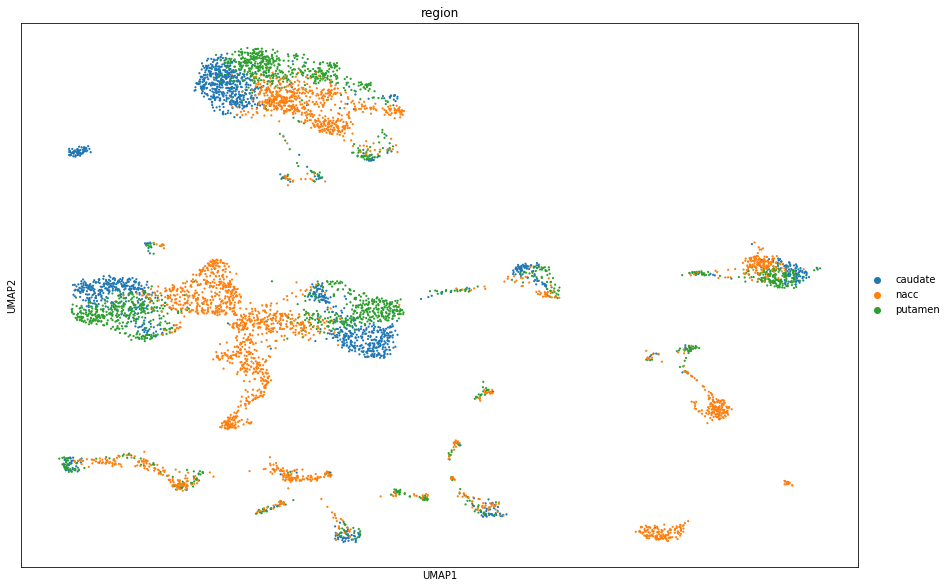

In [42]:

#first lets plot by brainregion
sc.pl.umap(striatum_ann,color="region")

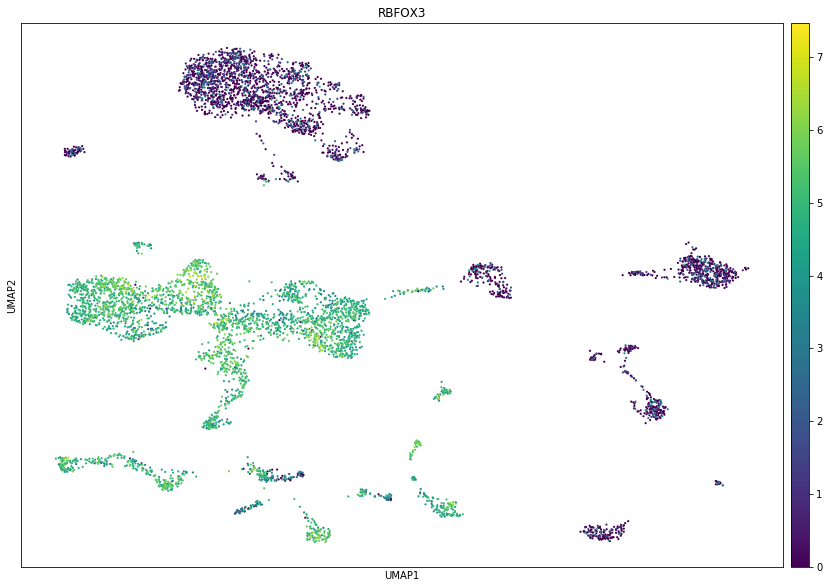

In [43]:
#neuronal marker plot
sc.pl.umap(striatum_ann,color="RBFOX3")

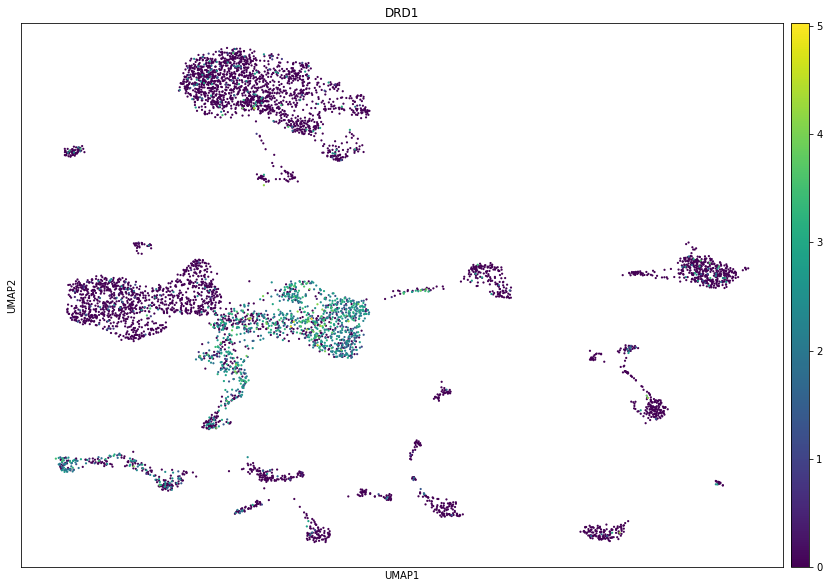

In [44]:
#D1 neuron marker plot
#we can clearly see nacc specific neuron D1 populations
sc.pl.umap(striatum_ann,color="DRD1")

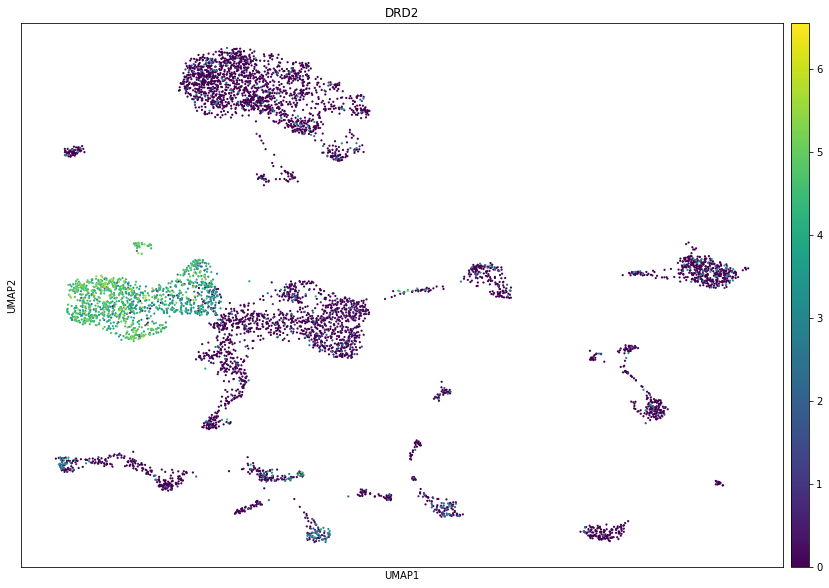

In [45]:
#D2 neuron marker plot
sc.pl.umap(striatum_ann,color="DRD2")

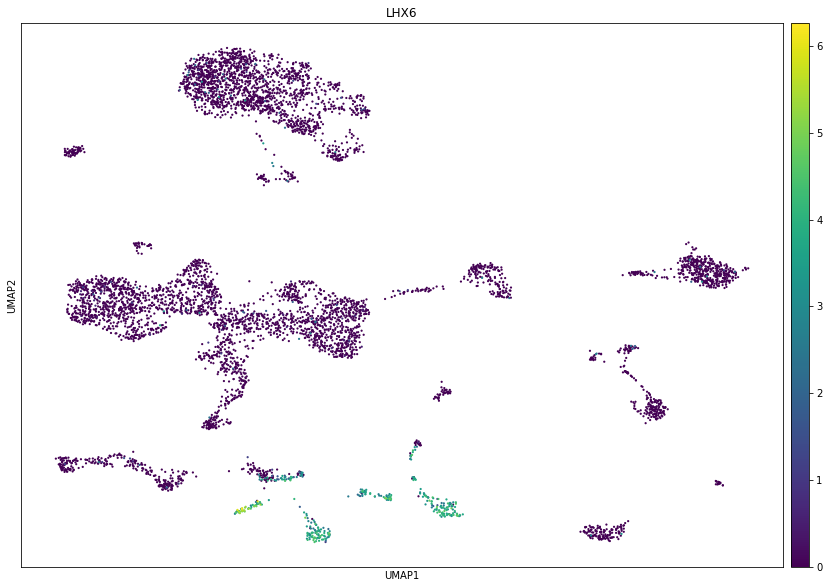

In [46]:
#Interneuron marker plot
sc.pl.umap(striatum_ann,color="LHX6")

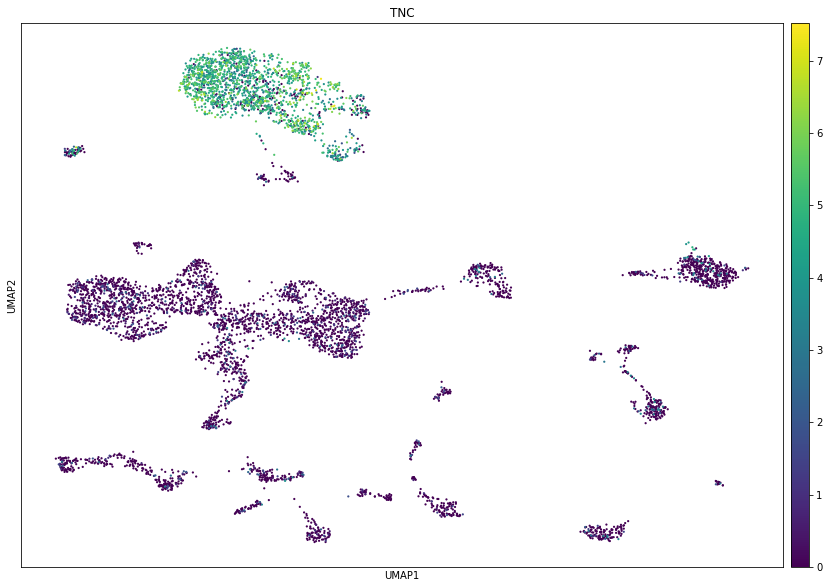

In [47]:
#Astrocyte marker plot
sc.pl.umap(striatum_ann,color="TNC")

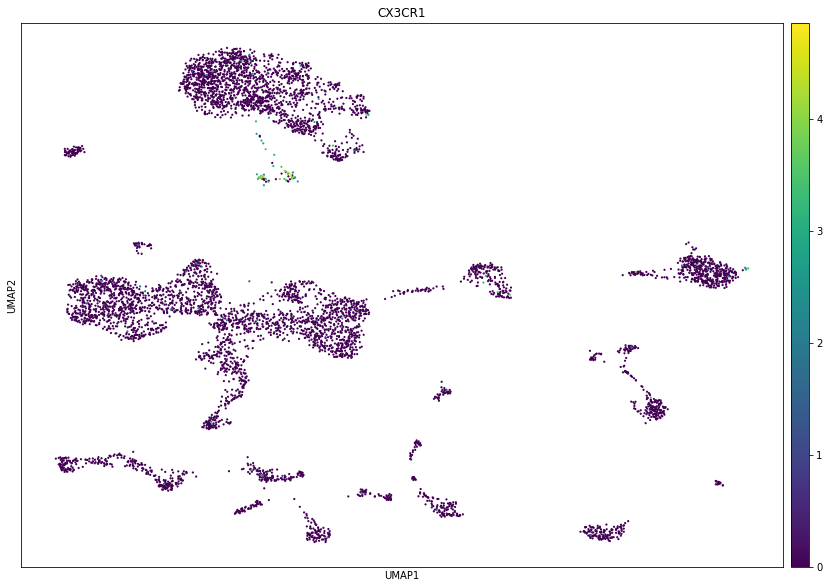

In [48]:
#Microglia marker plot
sc.pl.umap(striatum_ann,color="CX3CR1")

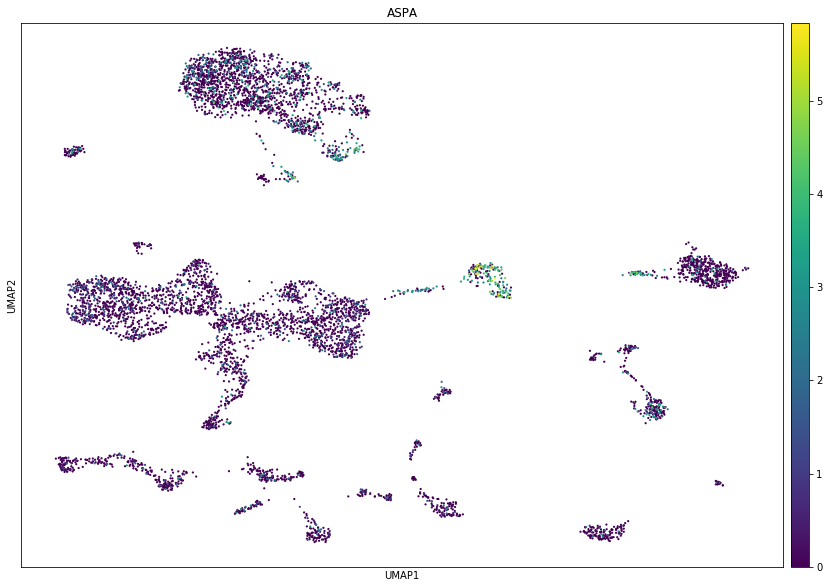

In [49]:
#Oligodendrocyte marker plot
sc.pl.umap(striatum_ann,color="ASPA")

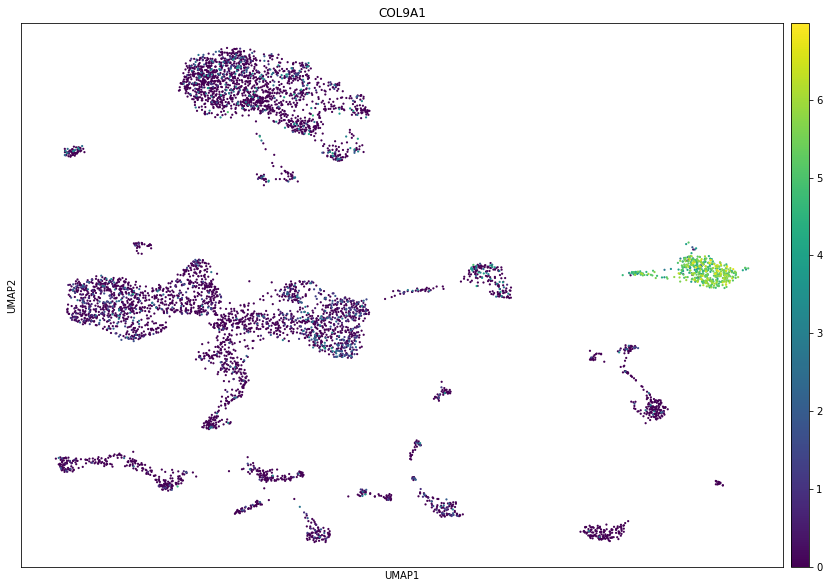

In [50]:
#Oligodencrocyte precursor plot
sc.pl.umap(striatum_ann,color="COL9A1")

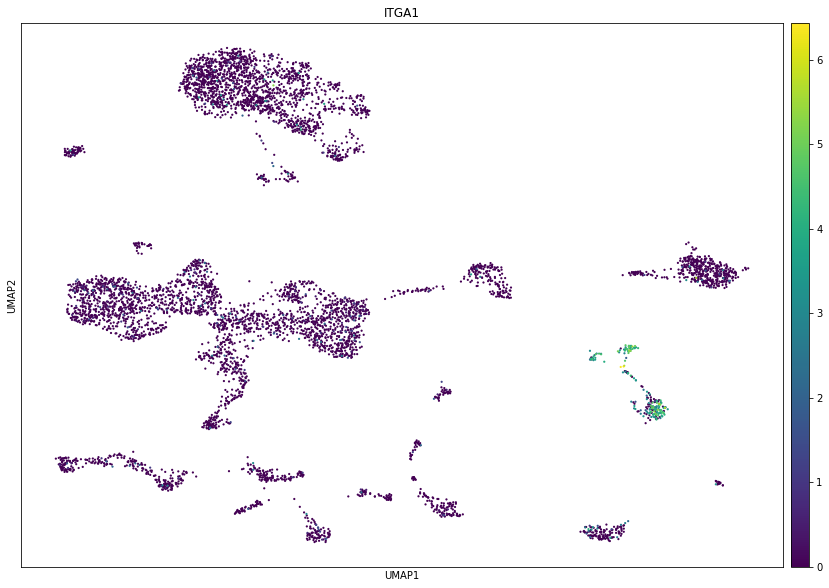

In [51]:
#Endothelial cell marker plot
sc.pl.umap(striatum_ann,color="ITGA1")

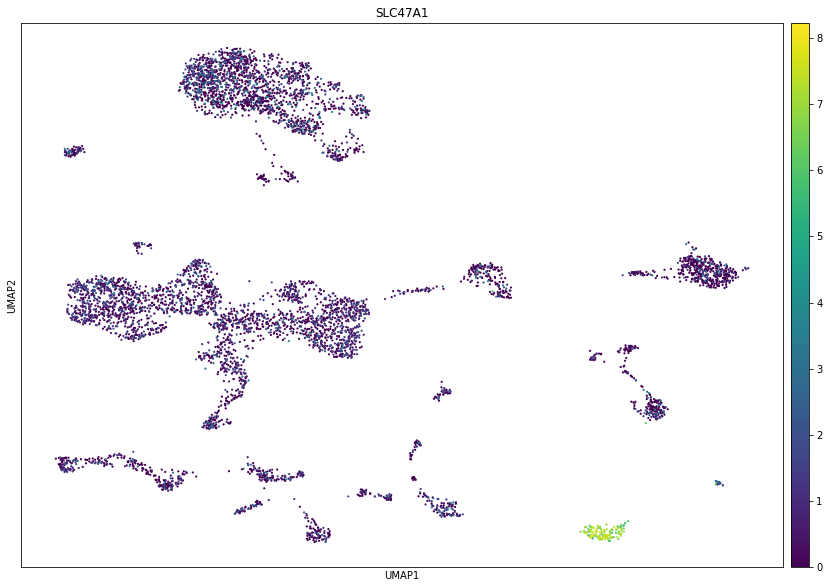

In [52]:
#Mural cell marker plot
sc.pl.umap(striatum_ann,color="SLC47A1")

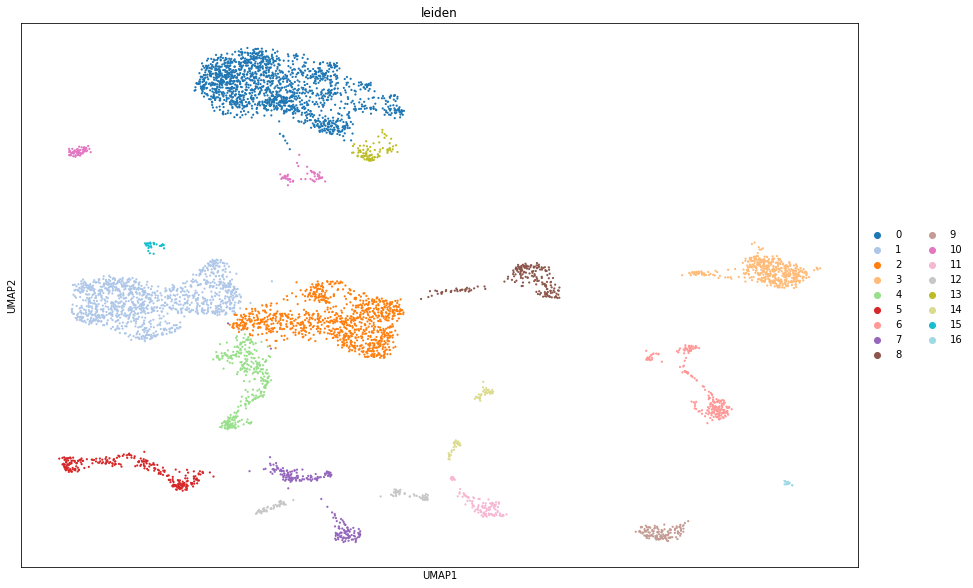

In [62]:
#now we are going to perform leiden clustering on the full population  doi: 10.1016/j.celrep.2016.06.059
sc.tl.leiden(striatum_ann,resolution=0.25)
sc.pl.umap(striatum_ann,color="leiden",palette="tab20")

In [63]:
#we can now load in previous study markers
gocke_et_al_markers = pd.read_csv("../data/raw/gocke_et_al_markers.csv")

In [70]:
from collections import defaultdict
gocke_marker_dict = defaultdict(set)
for i in range(gocke_et_al_markers.shape[0]):
    cell_type =gocke_et_al_markers["Cell Type "].values[i]
    gene = gocke_et_al_markers["gene"].values[i].upper()
    gocke_marker_dict[cell_type].add(gene)

In [85]:
##we are now going to assign the leiden clusters to cell types
from scipy.stats import hypergeom
cluster_assign_dict = {}

all_gene_set = set(straitum_norm_qc_nuclei.columns.values.tolist())
bonferroni_correction = np.unique(striatum_ann.obs["leiden"].values).size * len(gocke_marker_dict.keys())
for cluster in np.unique(striatum_ann.obs["leiden"].values):
    print("------------------------------------------------------------------------------")

    to_print = "CLUSTER: " + str(cluster)
    print(to_print)
    #calculate marker genes for each cluster
    is_mark = [ctype == cluster for ctype in striatum_ann.obs["leiden"].values]
    striatum_ann.obs["mark"] = pd.Categorical(
        values=is_mark,
        categories=[True, False])
    sc.tl.rank_genes_groups(striatum_ann, "mark")
    gene_set = set([tup[0].upper() for tup in striatum_ann.uns["rank_genes_groups"]["names"]])
    #print(gene_set)
    best_cell_type = "None"
    best_pvalue = 0.1
    pvals=[]
    cell_types=[]
    genes_found = []
    for cell_type in gocke_marker_dict:
        #intersect with gocke markers
        inter = gene_set.intersection(gocke_marker_dict[cell_type])
        all_inter = all_gene_set.intersection(gocke_marker_dict[cell_type])
        pval = hypergeom.sf(len(inter)-1,len(all_gene_set),len(all_inter),len(gene_set))*bonferroni_correction
        if pval< .1 and len(inter)>0:
            pvals.append(pval)
            cell_types.append(cell_type)
            genes_found.append(','.join(inter))
        if pval<best_pvalue:
            best_pvalue=pval,
            best_cell_type=cell_type
    result_dict= {"p_value": pvals, "label": cell_types, "query_match": genes_found}
    print(pd.DataFrame(result_dict))
    result_assignment = "Cluster "+ str(cluster)+" has been labeled as "+best_cell_type
    print(result_assignment)
    

------------------------------------------------------------------------------
CLUSTER: 0
        p_value       label                                        query_match
0  5.051641e-19  Astrocytes  SLC1A3,SLC1A2,EDNRB,RORB,BMPR1B,FGFR3,ATP1A2,A...
Cluster 0 has been labeled as Astrocytes
------------------------------------------------------------------------------
CLUSTER: 1
        p_value    label                                        query_match
0  4.606961e-23  Neurons  CELF5,RBFOX1,PTPN5,PDE10A,NDRG4,CACNA2D3,DLGAP...
Cluster 1 has been labeled as Neurons
------------------------------------------------------------------------------
CLUSTER: 10
        p_value         label                            query_match
0  4.377499e-09  Ependy Cilia  SPAG17,TTC29,LRRC36,VWA3A,HYDIN,ARMC4
Cluster 10 has been labeled as Ependy Cilia
------------------------------------------------------------------------------
CLUSTER: 11
Empty DataFrame
Columns: [p_value, label, query_match]
Index: []
Cl

In [73]:
cluster_assign_dict

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Neurons,0.0,13.0,13.0,0.0,11.0,6.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,3.0,5.0,0.0
Astrocytes,11.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,1.0
Oligo,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,2.0
Vascular,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
Microglia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
OPC,0.0,0.0,0.0,6.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,3.0,0.0,0.0,1.0,1.0
NSC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ependy Sec,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
Macrophage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
Ependy Cilia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#